# MAHTS generation

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry, CRS
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file
import mock
from affine import Affine
from datacube.utils.geometry import GeoBox

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import display_map
from dea_spatialtools import interpolate_2d
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_datahandling import mostcommon_crs


def get_geopoly(index, gdf):
    '''
    Selects a row from a geopandas.GeoDataFrame, and converts this
    into a geopolygon feature as an input to dc.load
    '''
    return Geometry(geo=gdf.loc[index].geometry.__geo_interface__, 
                    crs=CRS(gdf.crs['init']))


def interpolate_tide(timestep_ds, tidepoints_gdf, method='rbf', factor=20):    
    '''
    Extract a subset of tide modelling point data for a given time-step,
    then interpolate these tides into the extent of the xarray dataset.
    '''    
  
    # Extract subset of observations based on timestamp of imagery
    time_string = str(timestep_ds.time.values)[0:19].replace('T', ' ')
    tidepoints_subset = tidepoints_gdf.loc[time_string]
    print(time_string, end='\r')
    
    # Get lists of x, y and z (tide height) data to interpolate
    x_coords = tidepoints_subset.geometry.x,
    y_coords = tidepoints_subset.geometry.y,
    z_coords = tidepoints_subset.tide_m
    
    # Interpolate tides into the extent of the satellite timestep
    out_tide = interpolate_2d(ds=timestep_ds,
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              method=method,
                              factor=factor)
    
    # Return data as a Float32 to conserve memory
    return out_tide.astype(np.float32)


def load_tidal_subset(year_ds, tide_cutoff_min, tide_cutoff_max):
    
    # Print status
    year = year_ds.time[0].dt.year.item()
    print(f'Processing {year}')
    
    # Determine what pixels were acquired in selected tide range, and 
    # drop time-steps without any relevant pixels to reduce data to load
    tide_bool = ((year_ds.tide_m >= tide_cutoff_min) & 
                 (year_ds.tide_m <= tide_cutoff_max))
    year_ds = year_ds.sel(time=tide_bool.sum(dim=['x', 'y']) > 0)
    
    # Apply mask, and load in corresponding high tide data
    year_ds = year_ds.where(tide_bool)
    return year_ds.compute()

    
def tidal_composite(year_ds, 
                    label, 
                    label_dim, 
                    output_dir, 
                    output_prefix='',
                    export_geotiff=False):
    '''
    Loads data for a time period into memory, masks to keep only
    pixels observed at > median tide, takes median and counts of valid 
    water index results, and optionally writes each water index, tide 
    height and valid pixel counts for the time period to file
    '''
        
    # Compute median water indices and counts of valid pixels
    median_ds = year_ds.median(dim='time', keep_attrs=True)
    median_ds['count'] = (year_ds.mndwi
                          .count(dim='time', keep_attrs=True)
                          .astype('int16'))
    median_ds['stdev'] = year_ds.mndwi.std(dim='time', keep_attrs=True)
    
    # Write each variable to file  
    if export_geotiff:
        for i in median_ds:
            try:
                
                # Write using float nodata type
                geotiff_profile = {'blockxsize': 1024, 
                                       'blockysize': 1024, 
                                       'compress': 'deflate', 
                                       'zlevel': 5,
                                       'nodata': np.nan}
                
                write_geotiff(filename=f'{output_dir}/{output_prefix}{i}_{str(label)}.tif', 
                              dataset=median_ds[[i]],
                              profile_override=geotiff_profile)
            except:
                
                # Update nodata value for int data type
                geotiff_profile.update(nodata=-999)
                write_geotiff(filename=f'{output_dir}/{output_prefix}{i}_{str(label)}.tif', 
                              dataset=median_ds[[i]],
                              profile_override=geotiff_profile)
            
    # Set coordinate and dim
    median_ds = (median_ds
                 .assign_coords(**{label_dim: label})
                 .expand_dims(label_dim)) 
        
    return median_ds


In [2]:
dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')

### Set up Dask

In [3]:
# from datacube.utils.rio import configure_s3_access
# from datacube.utils.dask import start_local_dask
# import os
# import dask
# from dask.utils import parse_bytes

# # configure dashboard link to go over proxy
# dask.config.set({"distributed.dashboard.link":
#                  os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"});

# # Figure out how much memory/cpu we really have (those are set by jupyterhub)
# mem_limit = int(os.environ.get('MEM_LIMIT', '0'))
# cpu_limit = float(os.environ.get('CPU_LIMIT', '0'))
# cpu_limit = int(cpu_limit) if cpu_limit > 0 else 4
# mem_limit = mem_limit if mem_limit > 0 else parse_bytes('8Gb')

# # leave 4Gb for notebook itself
# mem_limit -= parse_bytes('4Gb')

# # close previous client if any, so that one can re-run this cell without issues
# client = locals().get('client', None)
# if client is not None:
#     client.close()
#     del client
    
# client = start_local_dask(n_workers=1,
#                           threads_per_worker=cpu_limit, 
#                           memory_limit=mem_limit)
# display(client)

# # Configure GDAL for s3 access 
# configure_s3_access(aws_unsigned=True,  # works only when reading public resources
#                     client=client);

### Connect to the datacube

In [157]:
dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')
# dc = datacube.Datacube(app='MAHTS_testing')

### Load virtual products catalogue


### Load tidal points


In [92]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')
comp_gdf = (gpd.read_file('input_data/50km_albers_grid_clipped.shp')
            .to_crs(epsg=4326)
            .set_index('id'))

In [181]:
study_area = 7631
query = {'geopolygon': get_geopoly(study_area, comp_gdf),
         'time': ('2018', '2018'),
         'cloud_cover': [0, 90],
         'dask_chunks': {'time': 1, 'x': 1000, 'y': 1000}}

# Preview study area
display_map(x=(query['geopolygon'].envelope.left, 
               query['geopolygon'].envelope.right), 
            y=(query['geopolygon'].envelope.top, 
               query['geopolygon'].envelope.bottom))

# # Preview study area
# display_map(x=query['x'], y=query['y'])

## Load virtual product

In [201]:
load_mndwi(query)

../Scripts/dea_datahandling.py:476: UserWarning: Multiple UTM zones ['epsg:32655', 'epsg:32656'] were returned for this query. Defaulting to the most common zone: epsg:32656
  UserWarning)


<xarray.Dataset>
Dimensions:  (time: 77, x: 867, y: 1804)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-02T23:52:50.270490 ... 2018-12-28T23:50:34.344980
  * y        (y) float64 -4.038e+06 -4.038e+06 ... -4.092e+06 -4.092e+06
  * x        (x) float64 2.222e+05 2.222e+05 2.223e+05 ... 2.482e+05 2.482e+05
Data variables:
    mndwi    (time, y, x) float32 dask.array<chunksize=(1, 1000, 867), meta=np.ndarray>
Attributes:
    crs:      epsg:32656

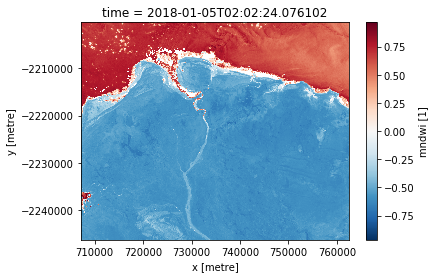

In [180]:
ds[['mndwi']].isel(time=0).mndwi.plot()
write_geotiff('vp_timestep6_average.tif', ds[['mndwi']].isel(time=0).compute())

In [183]:
ds[['mndwi']].load()
write_geotiff('vp_mndwi_average.tif', ds[['mndwi']].median(dim='time', keep_attrs=True))

In [184]:
ds = load_ard(dc=dc, 
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.0,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              output_crs=crs,
              resampling={'*': 'average', 'fmask': 'nearest', 'oa_fmask': 'nearest'},
              resolution=(-30, 30),  
              gqa_iterative_mean_xy=[0, 1],
              align=(15, 15),
              group_by='solar_day',
#               dask_chunks={'time': 1},
              mask_contiguity=False,
              mask_pixel_quality=True,
              **query)

ds = (calculate_indices(ds, index=['MNDWI'], 
                        collection='ga_ls_3', 
                        drop=True)
      .rename({'MNDWI': 'mndwi'}))

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Combining and sorting data
    Returning 77 observations as a dask array
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


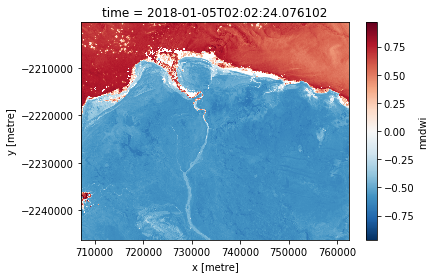

In [165]:
ds[['mndwi']].isel(time=0).mndwi.plot()
write_geotiff('loadard_timestep2_average.tif', ds[['mndwi']].isel(time=0).compute())

In [185]:
ds[['mndwi']].load()    

<xarray.Dataset>
Dimensions:  (time: 77, x: 867, y: 1804)
Coordinates:
  * x        (x) float64 2.222e+05 2.222e+05 2.223e+05 ... 2.482e+05 2.482e+05
  * y        (y) float64 -4.038e+06 -4.038e+06 ... -4.092e+06 -4.092e+06
  * time     (time) datetime64[ns] 2018-01-02T23:52:50.270490 ... 2018-12-28T23:50:34.344980
Data variables:
    mndwi    (time, y, x) float32 -0.19393937 -0.13272728 ... nan nan
Attributes:
    crs:      epsg:32656

In [186]:
write_geotiff('loadard_mndwi_average.tif', ds[['mndwi']].median(dim='time', keep_attrs=True))

## Model tides

In [ ]:
from shapely.geometry import shape
subset_gdf = points_gdf[points_gdf.geometry.intersects(shape(ds.geobox.geographic_extent.json))]
# subset_gdf = subset_gdf.iloc[::2, :]

# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'time': tidepoints_df.time, 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Fix time and set to index
tidepoints_gdf['time'] = pd.to_datetime(tidepoints_gdf['time'], utc=True)
tidepoints_gdf = tidepoints_gdf.set_index('time')

# Plot a sample timestep
ds.isel(time=0).mndwi.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

In [ ]:
import multiprocessing
from functools import partial

pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
print(f'Parallelising {multiprocessing.cpu_count() -1} processes')
tide_list = pool.map(partial(interpolate_tide, 
                             tidepoints_gdf=tidepoints_gdf, 
                             factor=50), 
                     iterable=[group for (i, group) in ds.groupby('time')])

# Interpolate tides for each timestep into the spatial extent of the data
ds['tide_m'] = xr.concat(tide_list, dim=ds.time)

# Determine tide cutoff
tide_cutoff_buff = ((ds['tide_m'].max(dim='time') - 
                     ds['tide_m'].min(dim='time')) * 0.25)  #.clip(0.0, 1.0)
tide_cutoff_min = 0.0 - tide_cutoff_buff
tide_cutoff_max = 0.0 + tide_cutoff_buff

In [ ]:
# Plot 
ds_i = ds['tide_m'].isel(time=10)
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(), 
                                                     vmax=ds_i.max().item())

## Generate yearly composites

In [ ]:
# If output folder doesn't exist, create it
output_dir = f'output_data/{study_area}'
os.makedirs(output_dir, exist_ok=True)

# Create empty vars containing un-composited data from the previous,
# current and future year. This is progressively updated to ensure that
# no more than 3 years of data are loaded into memory at any one time
previous_ds = None
current_ds = None
future_ds = None

# Iterate through each year in the dataset, starting at one year before
for year in np.unique(ds.time.dt.year) - 1:

    # Load data for the subsequent year
    future_ds = load_tidal_subset(ds.sel(time=str(year + 1)), 
                                  tide_cutoff_min=tide_cutoff_min,
                                  tide_cutoff_max=tide_cutoff_max)

    # If the current year var contains data, combine these observations
    # into median annual high tide composites and export GeoTIFFs
    if current_ds:

        # Generate composite
        tidal_composite(current_ds, 
                        label=year,
                        label_dim='year',
                        output_dir=output_dir, 
                        export_geotiff=True)        

    # If ALL of the previous, current and future year vars contain data,
    # combine these three years of observations into a single median 
    # 3-year gapfill composite
    if previous_ds and current_ds and future_ds:

        # Concatenate the three years into one xarray.Dataset
        gapfill_ds = xr.concat([previous_ds, current_ds, future_ds], 
                               dim='time')

        # Generate composite
        tidal_composite(gapfill_ds,
                        label=year,
                        label_dim='year',
                        output_dir=output_dir, 
                        output_prefix='gapfill_',
                        export_geotiff=True)        

    # Shift all loaded data back so that we can re-use it in the next
    # iteration and not have to load the same data multiple times
    previous_ds = current_ds
    current_ds = future_ds
    future_ds = []


In [ ]:
tidal_composite(current_ds, 
                        label=year,
                        label_dim='year',
                        output_dir=output_dir, 
                        export_geotiff=True) 

In [ ]:
year

In [ ]:
# '_get_index_and_items',
#  '_group',
#  '_group_dim',
#  '_group_indices',
#  '_groups',

# dir(ds.groupby('time.year'))
# i, year = 0, np.unique(ds.time.dt.year)[0]

In [ ]:
# previous_ds = []
# current_ds = []
# future_ds = []

In [ ]:
# Plot
# yearly_ds['count'].sum(dim='year').plot(size=10, robust=True)

In [ ]:
# yearly_ds.geobox.transform

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)